In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy import signal
from scipy import stats

import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# for svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

In [7]:
# Import data

Standing = pd.read_excel(r'..\..\dataArticle\privateData\Standing.xlsx')
Standing.columns
Standing = Standing.drop(['Standing'], axis = 1)

Index(['Standing', 'x', 'y', 'z'], dtype='object')

In [3]:
Sitting = pd.read_excel(r'..\..\dataArticle\privateData\Sitting.xlsx')

Sitting.columns
Sitting = Sitting.drop(['Time_Sitting'], axis = 1)
Sitting.columns

# normalize Sitting 
G = 9.80665
Sitting['x'] = Sitting['x'].div(G)
Sitting['y'] = Sitting['y'].div(G)
Sitting['z'] = Sitting['z'].div(G)

Index(['Time_Sitting', 'x', 'y', 'z'], dtype='object')

Index(['x', 'y', 'z'], dtype='object')

In [4]:
Running = pd.read_excel(r'..\..\dataArticle\privateData\Running.xlsx')
Running.columns

Running = Running.drop(['Running','Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14'], axis = 1)
Running.columns

Index(['Running', 'x', 'y', 'z', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14'],
      dtype='object')

Index(['x', 'y', 'z'], dtype='object')

In [5]:
Walking = pd.read_excel(r'..\..\dataArticle\privateData\Slow_Walking.xlsx')
Walking.columns

Walking = Walking.drop(['Slow_Walking'], axis = 1)
Walking.columns

Index(['Slow_Walking', 'x', 'y', 'z'], dtype='object')

Index(['x', 'y', 'z'], dtype='object')

In [8]:
print(len(Standing))
print(len(Sitting))
print(len(Running))
print(len(Walking))

129420
28755
29619
66510


In [ ]:
# check nan value
Standing.isnull().sum().sum()
Sitting.isnull().sum().sum()
Running.isnull().sum().sum()
Walking.isnull().sum().sum()

0

0

0

0

In [10]:
# Split dataset to 2 parts: Train (60%) - Test (40%)
# Standing, Running, Walking: Fs = 50 Hz

frame = 500
stride = 250

def splitDatasetToTrain (dataAction, ratio = 0.6):
    return [dataAction[i:i+frame] for i in range(0, int(len(dataAction)*ratio), stride)]

def splitDatasetToTest (dataAction, ratio = 0.4):
    return [dataAction[i:i+frame] for i in range(int(len(dataAction)*(1-ratio)), 
                                len(dataAction), stride) if i+frame <= len(dataAction)]


X_stand_train = splitDatasetToTrain(Standing)
X_stand_test = splitDatasetToTest(Standing)

X_run_train = splitDatasetToTrain(Running)
X_run_test = splitDatasetToTest(Running)

X_walk_train = splitDatasetToTrain(Walking)
X_walk_test = splitDatasetToTest(Walking)

print ('X_stand_train: ', len(X_stand_train))
print ('X_stand_test: ', len(X_stand_test))

print ('X_run_train: ', len(X_run_train))
print ('X_run_test: ', len(X_run_test))

print ('X_walk_train: ', len(X_walk_train))
print ('X_walk_test: ', len(X_walk_test))

X_stand_train:  311
X_stand_test:  206
X_run_train:  72
X_run_test:  46
X_walk_train:  160
X_walk_test:  105


In [17]:
# Split dataset to 2 parts: Train (60%) - Test (40%)
# Sitting: Fs = 15 Hz 

frame = 150
stride = 75

X_sit_train = splitDatasetToTrain(Sitting)
X_sit_test = splitDatasetToTest(Sitting)

print ('X_sit_train: ', len(X_sit_train))
print ('X_sit_test: ', len(X_sit_test))

X_sit_train:  231
X_sit_test:  152


In [18]:
# Don't know how many variables when creating function => use splat operator.

def mergeArrayAction (*dataActions):
    data = {
        "data": [],
        "label": []
    }
    index = 0
    for dataAction in dataActions: 
        for act in dataAction: 
            data["data"].append(act)
            data["label"].append(index)
        index += 1
    return data

dataTrain = mergeArrayAction(
    X_stand_train,
    X_sit_train,
    X_run_train,
    X_walk_train, 
)

dataTest = mergeArrayAction(
    X_stand_test,
    X_sit_test,
    X_run_test,
    X_walk_test
)

train_data = dataTrain["data"]
train_label = dataTrain["label"]

test_data = dataTest["data"]
test_label = dataTest["label"]

print('train-data length: ', len(train_data))
print('train-label length: ', len(train_label))
print('test-data length: ', len(test_data))
print('test-label length: ', len(test_label))

train-data length:  774
train-label length:  774
test-data length:  509
test-label length:  509


In [19]:
# Extract features

def featuresFromBuffer(at):
    feat = np.zeros(15)   
    
    x = np.array(at.iloc[:,0], dtype=np.float64)   
    y = np.array(at.iloc[:,1], dtype=np.float64)   
    z = np.array(at.iloc[:,2], dtype=np.float64)  
    
    means = [np.mean(i) for i in [x, y, z]]
    feat[0:3] = means 
    
    rms = [np.sqrt(np.mean(i**2)) for i in [x, y, z]]
    feat[3:6] = rms

    # Standard deviation
    std = [np.std(i) for i in [x, y, z]]
    feat[6:9] = std

    # Median
    med = [np.median(i) for i in [x, y, z]]
    feat[9:12] = med
    
    # Range
    Range = [np.amax(i)-np.amin(i) for i in [x, y, z]]    
    feat[12:15] = Range
    
    return feat  

In [20]:
# Create features array
train_features = []
test_features = []
for action in train_data:
    feat = featuresFromBuffer(action)
    train_features.append(feat)  

for action in test_data:
    feat = featuresFromBuffer(action)
    test_features.append(feat)

len(train_features)
len(test_features)

774

509

In [21]:
# Handle nan value
np.where(np.isnan(train_features)) 
train_features = np.nan_to_num(train_features)
np.where(np.isnan(test_features))
test_features = np.nan_to_num(test_features)      

len(train_features)
len(train_label)

(array([], dtype=int64), array([], dtype=int64))

(array([], dtype=int64), array([], dtype=int64))

774

774

In [33]:
#Classifier 
from sklearn.feature_selection import SelectFromModel
print("Gradient Boosting Decision Tree:")
from sklearn.ensemble import GradientBoostingClassifier
clf1 = GradientBoostingClassifier(learning_rate=0.05,max_depth=3,n_estimators=100).fit(train_features, train_label)
#format: pass score in {:.3f}
print('Accuracy of GBDT classifier on training set: {:.3f}'
     .format(clf1.score(train_features, train_label)))
print('Accuracy of GBDT classifier on test set: {:.3f}'
     .format(clf1.score(test_features, test_label)))

print("\nDecision Tree:") 
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree 

clf2 = DecisionTreeClassifier(max_depth=4).fit(train_features, train_label)

print('Accuracy of Decision Tree classifier on training set: {:.3f}'.format(clf2.score(train_features, train_label)))
print('Accuracy of Decision Tree classifier on test set: {:.3f}'
.format(clf2.score(test_features, test_label)))


print("\nSVM:")
clf3 = SVC(C=100, gamma='scale').fit(train_features, train_label)
print("Accuracy on training set: {:.2f}".format(clf3.score(train_features, train_label)))
print("Accuracy on test set: {:.2f}".format(clf3.score(test_features, test_label)))


print('\nRandom Forests: ')
from sklearn.ensemble import RandomForestClassifier
clf4 = RandomForestClassifier(n_estimators=200, random_state=0).fit(train_features, train_label)

print('Accuracy of RF classifier on training set: {:.3f}'
     .format(clf4.score(train_features, train_label)))
print('Accuracy of RF classifier on test set: {:.3f}'
     .format(clf4.score(test_features, test_label)))


print('\nKNeighbor: ')
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance').fit(train_features, train_label)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(train_features, train_label)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(test_features, test_label)))


Gradient Boosting Decision Tree:
Accuracy of GBDT classifier on training set: 1.000
Accuracy of GBDT classifier on test set: 0.990

Decision Tree:
Accuracy of Decision Tree classifier on training set: 0.997
Accuracy of Decision Tree classifier on test set: 0.988

SVM:
Accuracy on training set: 0.98
Accuracy on test set: 0.99

Random Forests: 
Accuracy of RF classifier on training set: 1.000
Accuracy of RF classifier on test set: 0.992

KNeighbor: 
Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.99


<Figure size 560x400 with 0 Axes>

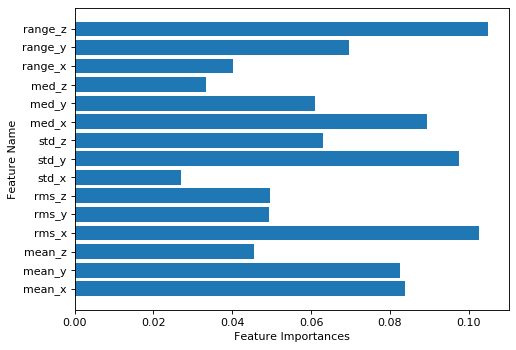

Feature importances: [0.08398219 0.0825203  0.0454339  0.10259052 0.04932743 0.04964313
 0.02691313 0.09764629 0.06303616 0.08955098 0.06095139 0.03338651
 0.04030411 0.06976463 0.10494933]


In [23]:
# adspy_shared_utilities import plot_feature_importances
# Atturibute Feature importances only use for classifiers contain trees

feature_names = ['mean_x', 'mean_y', 'mean_z', 
                'rms_x', 'rms_y', 'rms_z',
                'std_x', 'std_y', 'std_z',
                'med_x', 'med_y', 'med_z',
                'range_x','range_y','range_z']

def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature Importances")
    plt.ylabel("Feature Name")
    plt.yticks(np.arange(c_features), feature_names)
    
plt.figure(figsize=(7,5), dpi=80)
plot_feature_importances(clf4, feature_names)
plt.show()

print('Feature importances: {}'.format(clf4.feature_importances_))

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
      
y_pred = clf4.predict(test_features)

print('micro')
f1_score(test_label, y_pred, average='micro')
recall_score(test_label, y_pred, average='micro')
precision_score(test_label, y_pred, average='micro',labels=np.unique(y_pred))

#overall measurement
print('macro')
f1_score(test_label, y_pred, average='macro')
recall_score(test_label, y_pred, average='macro')
precision_score(test_label, y_pred, average='macro',labels=np.unique(y_pred))

micro


0.9921414538310412

0.9921414538310412

0.9921414538310412

macro


0.9847508499046896

0.9851047455595511

0.9844134536505331

Confusion matrix, without normalization
[[206   0   0   0]
 [  0 151   1   0]
 [  0   0  44   2]
 [  0   0   1 104]]
Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.99 0.01 0.  ]
 [0.   0.   0.96 0.04]
 [0.   0.   0.01 0.99]]


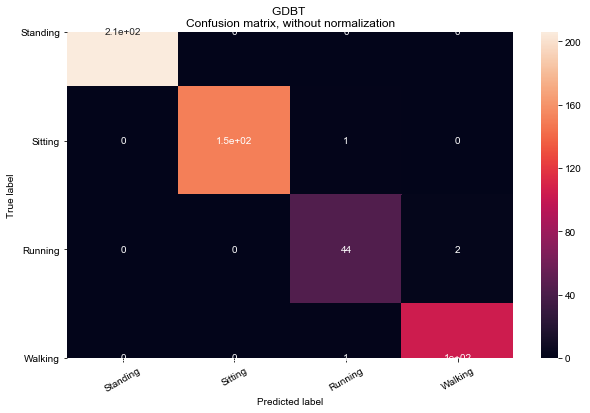

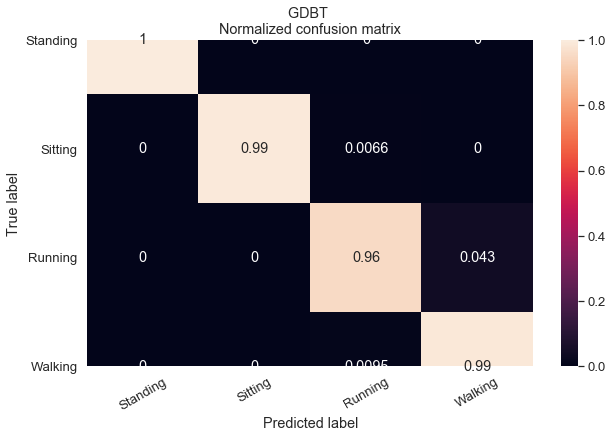


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       206
           1       1.00      0.99      1.00       152
           2       0.96      0.96      0.96        46
           3       0.98      0.99      0.99       105

    accuracy                           0.99       509
   macro avg       0.98      0.99      0.98       509
weighted avg       0.99      0.99      0.99       509



In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sb
from sklearn.utils.multiclass import unique_labels

target_names = ['Standing', 'Sitting', 'Running', 'Walking']

y_pred = clf4.predict(test_features)
lables = np.concatenate([target_names, ])

from sklearn.metrics import f1_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False, title=None):
    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    fig, ax = plt.subplots(figsize = (10,6))
    dataFrame = pd.DataFrame(cm)
    sb.heatmap(dataFrame, annot = True)  
    ax.set(xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    sb.set(font_scale = 1.2)

np.set_printoptions(precision=2)

plot_confusion_matrix(test_label, y_pred, classes=lables,  
        title='GDBT \nConfusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(test_label, y_pred, classes=lables, normalize=True,
        title='GDBT \nNormalized confusion matrix')

plt.show()
print ("\nClassification Report: ")
print (classification_report(test_label, y_pred,labels=np.unique(y_pred)))


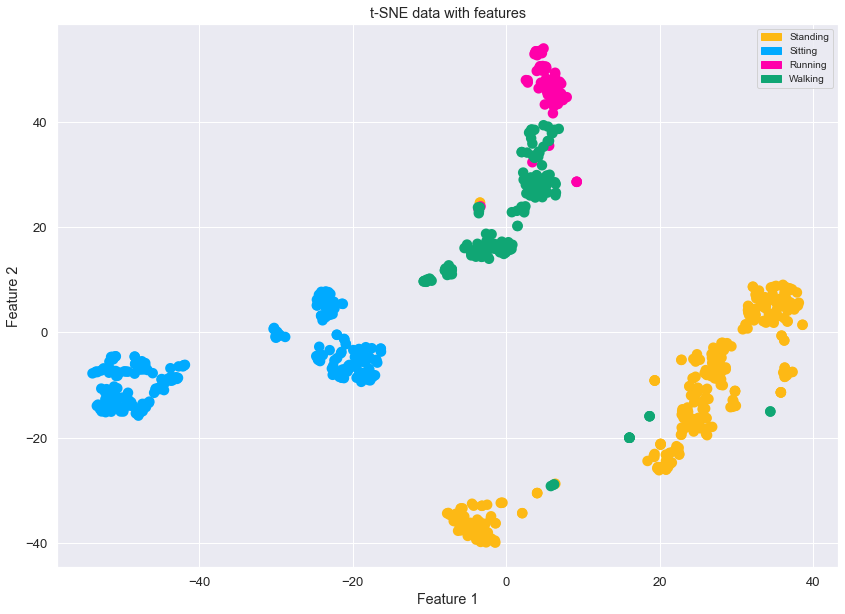

In [26]:
# t-SNE 

import numpy
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import graphviz 
from sklearn.tree import export_graphviz
import matplotlib.patches as mpatches


def plot_labelled_scatter(X, y, class_labels): 
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1   
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1  
    
    colors = ['#fdb915', '#00AAFF', '#FF00AA','#10a674'] 
  
    cmap = ListedColormap(colors) 

    norm = BoundaryNorm(numpy.arange(0, num_labels+1, 1), ncolors=num_labels) 
    
    plt.figure(figsize=(14,10))
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=cmap, norm=norm, alpha=1, lw=5)
                #edgecolor='black'
    
    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=colors[c], label=class_labels[c])) 
    plt.legend(handles=h, fontsize = 'x-small')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('t-SNE data with features')

    plt.show()
    
X_visual = train_features
y_visual = np.array(train_label, dtype=np.uint8) 

n_samples = 300
n_components = 2  # dimension
perplexity = 30.0 
RS = 1000   

from sklearn.manifold import TSNE 
X_tsne = TSNE(random_state=RS, n_components=2, perplexity=30.0, learning_rate=300.0 ).fit_transform(X_visual)            
plot_labelled_scatter(X_tsne, y_visual,['Standing','Sitting','Running','Walking'])

In [27]:
# tsne for orginal data
# instead train_features by train_data

new_train = np.array(train_data[0])
for i in range(1, len(train_data)):
    new_train = np.concatenate((new_train,np.array(train_data[i])))
new_train
len(new_train)
new_train.shape

new_train = np.resize(new_train,(train_features.shape))
new_train.shape

array([[ 0.  ,  0.  ,  1.01],
       [-0.21,  0.  ,  1.  ],
       [-0.19,  0.  ,  1.  ],
       ...,
       [-0.93,  0.22, -0.13],
       [-0.96,  0.13, -0.15],
       [-0.96,  0.1 , -0.13]])

306150

(306150, 3)

(774, 15)

4


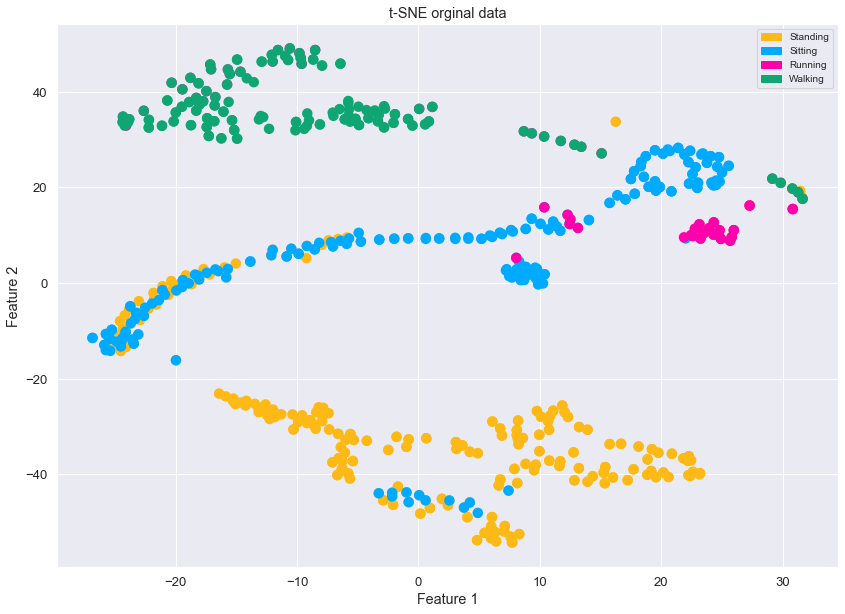

In [28]:
# t-SNE orginal data

import numpy
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import graphviz 
from sklearn.tree import export_graphviz
import matplotlib.patches as mpatches


def plot_labelled_scatter(X, y, class_labels): 
    num_labels = len(class_labels)
    print(num_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1   
    colors = ['#fdb915', '#00AAFF', '#FF00AA', '#10a674']
  
    cmap = ListedColormap(colors) 
    
    norm = BoundaryNorm(numpy.arange(0, num_labels+1, 1), ncolors=num_labels) 
    
    plt.figure(figsize=(14, 10))
    
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=cmap, norm=norm, alpha=1, lw=5)
                #edgecolor='black'

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=colors[c], label=class_labels[c])) 
    plt.legend(handles=h, fontsize = 'x-small') 
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('t-SNE orginal data')

    plt.show()
    
X_orginal = new_train
y_orginal = np.array(train_label, dtype=np.uint8) 

n_samples = 300
n_components = 2  # dimension
perplexity = 30.0 
RS = 1000   

from sklearn.manifold import TSNE 
X_tsne = TSNE(random_state=RS, n_components=2, perplexity=30.0, learning_rate=300.0 ).fit_transform(X_orginal)    
#, n_components=2, perplexity=30.0, learning_rate=300.0 
plot_labelled_scatter(X_tsne, y_visual,['Standing','Sitting','Running','Walking'])

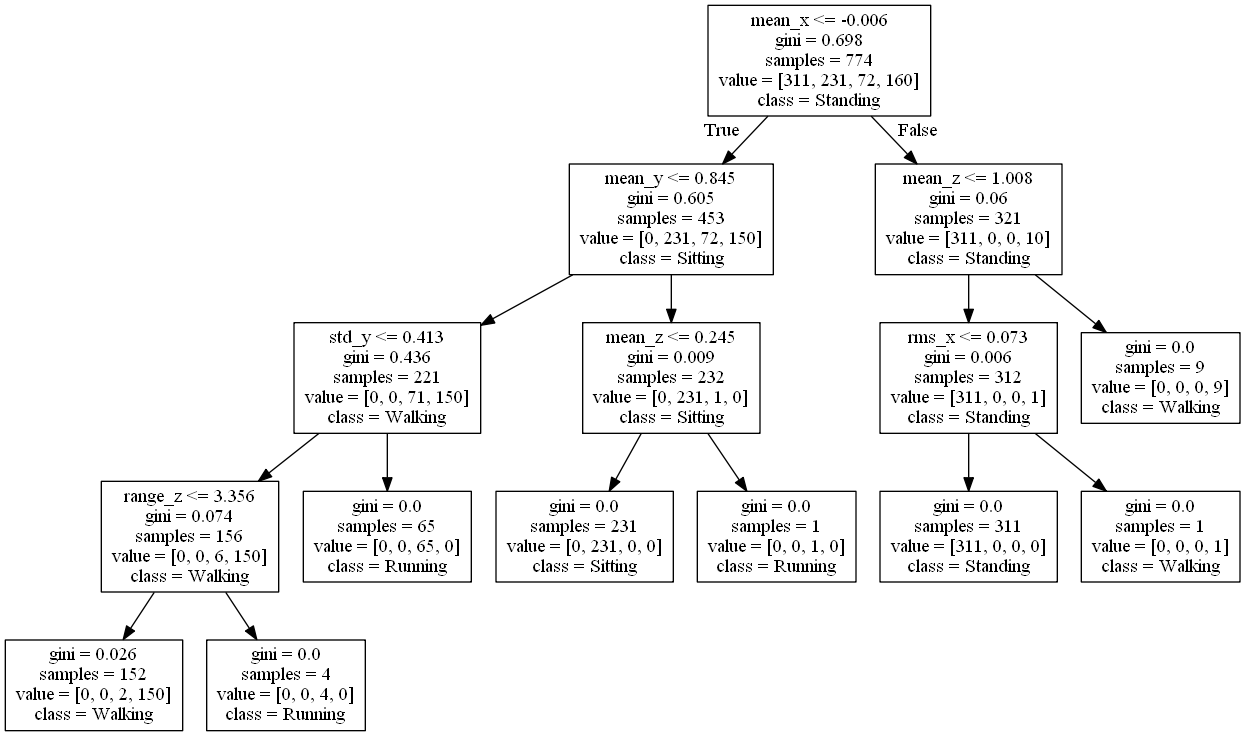

True

In [29]:
#Visualize A Decision Tree

import graphviz
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree
from IPython.display import Image
from sklearn import tree
import pydotplus

import os
os.environ["PATH"] += os.pathsep + r'F:\Python file\Graphviz\bin'
# Create DOT data
dot_data = tree.export_graphviz(clf2, out_file=None,
                               feature_names = feature_names,
                               class_names = target_names)
# Draw graph                               
pydot_graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph                            
Image(pydot_graph.create_png()) 

#Create png
pydot_graph.write_pdf("tree.pdf")

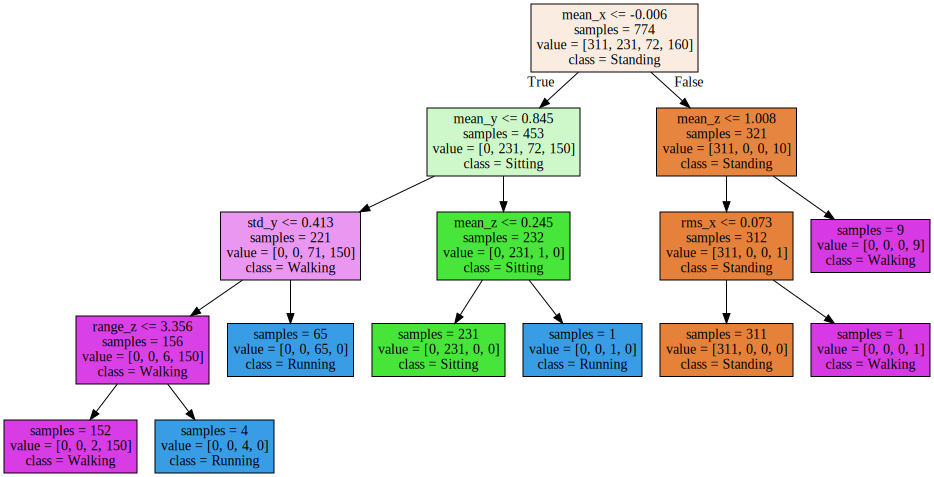

In [30]:
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree

plot_decision_tree(clf2, feature_names, target_names)
#Image(graph.create_png())

In [31]:
tree.export_graphviz(clf2, out_file="tree.png", feature_names=feature_names, class_names=target_names, filled=True, rounded=True)

In [32]:
# Save DT into pdf file 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz


from sklearn.tree import export_graphviz
export_graphviz(clf2, out_file="tree.dot",feature_names=feature_names,class_names=target_names, impurity=False, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()
g = graphviz.Source(dot_graph)
g.render()

'Source.gv.pdf'